## STEP0 ライブラリのインポートとデータの確認

### ライブラリのインポートと作業ディレクトリの確認

In [118]:
# 必要なライブラリをプログラムに読み込む
import os # osライブラリ：ファイルやディレクトリを操作するためのライブラリ
import pandas as pd # pandasライブラリ：データ分析を行うためのツール
import numpy as np # numpyライブラリ：数値計算、特に配列や行列の計算を行うツール

# 現在どのディレクトリ（フォルダ）で作業しているか確認
print(os.getcwd())

/Users/chise1/Desktop/日揮インターン/kadai1


### データ読み込みと初期確認

In [121]:
# pandasを使ってCSVファイルを読み込み'df'（データフレーム（表））に格納
df = pd.read_csv('Data/Baseball Notes.csv')

In [123]:
# 'df.head()'を使って、読み込んだデータの最初の5行を表示
# データがどのように読み込まれたのか確認できる
df.head()

,"date,player_id,grade,position,note"
0,"2025-04-01,P01,1,投手,【練習初日】今日から新年度の練習が始まった。藤井監督..."
1,"2025-04-01,P02,1,外野手,【練習初日】今日から本格的に練習スタート！声出しで..."
2,"2025-04-01,P03,1,捕手,【練習初日】新チームでの練習初日。キャッチャーとして..."
3,"2025-04-01,P04,1,内野手,【練習初日】2年の先輩たちの動きがやっぱりすごい。..."
4,"2025-04-01,P05,1,一塁手,【練習初日】新しい環境での練習はまだ少し緊張する。..."


## STEP1 データの前処理
#### 目的：1列に結合されてしまっているデータを、意味のある複数の列（日付、選手IDなど）に分割。分析しやすい形に形成

### ヘッダーなしで再度読み込み

In [127]:
# 元のCSVを読み込む（1セルに全部入っている状態）
df_raw = pd.read_csv('Data/Baseball Notes.csv', header=None)
# 'headar=None'とすることで、1行目をヘッダーとして扱わず、すべてデータとして読み込む。

### データの分割

In [130]:
# 先頭から4つのカンマでだけ分割（= 5列に固定）
df_split = df_raw[0].str.split(',', n=4, expand=True)
# n=4：最初の4つのカンマだけで分割するように指定する。
# 野球ノートの本文中にカンマが含まれている可能性があるため、意図せずデータが6列以上に別れてしまうのを防いでいる。
# 'expand=True'：分割した結果を新しい列としてデータフレームに展開

### 列名（ヘッダー）の設定

In [133]:
# 分割したデータフレームに列名を付ける
df_split.columns = ['date', 'player_id', 'grade', 'position', 'note']

### ヘッダー行の削除

In [136]:
# 見出し行を除去（日付形式がYYYY-MM-DDである前提）
tmp = pd.to_datetime(df_split['date'], format='%Y-%m-%d', errors='coerce')
df_split = df_split[tmp.notna()].copy()
# CSVの1行目がデータとして残ってしまっているため、削除する。
# 'pd.to_datetime'を使って'date'列を日付形式に変換しようと試み、'errors='coerce'で変換できないもの（ヘッダー行など）をNot（Not a Time）という欠損値にする。
# 'tmp.notna()'で、日付形式に正しく変換できた行（NoTでない行）だけ抽出する。→ヘッダー行が綺麗に削除される。

### 不要な空白の除去

In [139]:
# 余計な空白を除去(コンマの後の半角スペースを削除)
# 分割時にカンマの後ろに半角スペースなどが含まれている場合があるため、'str.strip()'を使って各列のデータから前後の不要な空白を削除する。
for c in ['date','player_id','grade','position']:
    df_split[c] = df_split[c].str.strip()

### 前処理結果の確認

In [142]:
# 'df_split.shape'で、データフレームの行数と列数を確認する。（結果：2184行、5列）
print(df_split.shape)

# 'df_split.head()'で、前処理後のデータの先頭5行を表示して、ただ軸処理されているかを確認する。
df_split.head()

(2184, 5)


,date,player_id,grade,position,note
1,2025-04-01,P01,1,投手,【練習初日】今日から新年度の練習が始まった。藤井監督から「基本を大事にしろ」というお話があっ...
2,2025-04-01,P02,1,外野手,【練習初日】今日から本格的に練習スタート！声出しで気合を入れた。大輔コーチが「元気があってい...
3,2025-04-01,P03,1,捕手,【練習初日】新チームでの練習初日。キャッチャーとして投手の球をしっかり受け止めないといけない...
4,2025-04-01,P04,1,内野手,【練習初日】2年の先輩たちの動きがやっぱりすごい。でも絶対に負けたくない。特に同じポジション...
5,2025-04-01,P05,1,一塁手,【練習初日】新しい環境での練習はまだ少し緊張する。都会の練習はペースが速いなと感じた。まずは...


In [144]:
# データ全体の概要を把握する。
print('形状:', df_split.shape)          # 行数：5行
print('列名:', list(df_split.columns))  # 5列の名前
print('欠損数:\n', df_split.isna().sum()) # isna().sum()で各列の欠損値の数を確認。全て0ならOK 結果：OK
print('player_idの一意数:', df_split['player_id'].nunique()) # nunique()で選手IDが何種類あるか（選手の人数）を確認。
df_split.sample(3, random_state=0)

形状: (2184, 5)
列名: ['date', 'player_id', 'grade', 'position', 'note']
欠損数:
 date         0
player_id    0
grade        0
position     0
note         0
dtype: int64
player_idの一意数: 24


,date,player_id,grade,position,note
1694,2025-06-10,P14,2,一塁手,バッティングフォームが、固まってきた気がする。大輔コーチと、二人三脚で作り上げてきたフォーム...
462,2025-04-20,P06,1,三塁手,【練習試合】今日もデータが活きた。相手の継投のタイミングを予測し、監督に進言した。それが、見...
1313,2025-05-25,P17,3,投手,【紅白戦2日目】主将として、レギュラー組の敗戦は、自分の責任だ。チームに、慢心があったのかも...


## STEP2 自然言語処理（テキストデータの数値化準備）
#### 目的：野球ノートのテキスト（自然言語）を、コンピュータが分析しやすいように単語のリストに変換する（形態要素解析）。

### 形態素解析ライブラリの準備と実行例

In [148]:
from fugashi import Tagger # 'fugashi'は、日本語の形態素分析エンジンMeCabをPythonから使いやすくするためのライブラリ
tagger = Tagger()

# 最初の行のノートをサンプルとして、形態素解析の結果を確認する。
sample = df_split.iloc[0]['note']   # ← これなら必ず先頭行を取れる
print('原文:', sample)

print('分かち書き（表層形 / 原形 / 品詞）:')
for w in tagger(str(sample)):
    surface = w.surface # 単語のそのままの形（例：「始まった」）
    lemma   = getattr(w.feature, 'lemma', None) or surface # 単語の原形（例：「始まる」）
    pos1    = getattr(w.feature, 'pos1', '') # 品詞（例：「動詞」）
    print(f'{surface}\t→\t{lemma}\t({pos1})')

原文: 【練習初日】今日から新年度の練習が始まった。藤井監督から「基本を大事にしろ」というお話があった。塚本コーチが教えてくれた新しいフォームを忘れないように、ノートに細かくメモしておこう。先輩たちみたいにうまくなりたい。
分かち書き（表層形 / 原形 / 品詞）:
【	→	【	(補助記号)
練習	→	練習	(名詞)
初日	→	初日	(名詞)
】	→	】	(補助記号)
今日	→	今日	(名詞)
から	→	から	(助詞)
新	→	新	(接頭辞)
年度	→	年度	(名詞)
の	→	の	(助詞)
練習	→	練習	(名詞)
が	→	が	(助詞)
始まっ	→	始まる	(動詞)
た	→	た	(助動詞)
。	→	。	(補助記号)
藤井	→	フジイ	(名詞)
監督	→	監督	(名詞)
から	→	から	(助詞)
「	→	「	(補助記号)
基本	→	基本	(名詞)
を	→	を	(助詞)
大事	→	大事	(形状詞)
に	→	だ	(助動詞)
しろ	→	為る	(動詞)
」	→	」	(補助記号)
と	→	と	(助詞)
いう	→	言う	(動詞)
お	→	御	(接頭辞)
話	→	話	(名詞)
が	→	が	(助詞)
あっ	→	有る	(動詞)
た	→	た	(助動詞)
。	→	。	(補助記号)
塚本	→	ツカモト	(名詞)
コーチ	→	コーチ-coach	(名詞)
が	→	が	(助詞)
教え	→	教える	(動詞)
て	→	て	(助詞)
くれ	→	呉れる	(動詞)
た	→	た	(助動詞)
新しい	→	新しい	(形容詞)
フォーム	→	フォーム-form	(名詞)
を	→	を	(助詞)
忘れ	→	忘れる	(動詞)
ない	→	ない	(助動詞)
よう	→	様	(形状詞)
に	→	だ	(助動詞)
、	→	、	(補助記号)
ノート	→	ノート-note	(名詞)
に	→	に	(助詞)
細かく	→	細かい	(形容詞)
メモ	→	メモ-memo	(名詞)
し	→	為る	(動詞)
て	→	て	(助詞)
おこう	→	置く	(動詞)
。	→	。	(補助記号)
先輩	→	先輩	(名詞)
たち	→	達	(接尾辞)
みたい	→	みたい	(形状詞)
に	→	だ	(助動詞)
うまく	→	旨い	(形容詞)
なり	→	成る	(動詞)
たい	→	たい	(助動詞)
。	→	。	(補助記号)


### 形態素解析と内容語抽出の関数化

In [151]:
# テキストを単語の「原形（lemma）」のリストに変換する関数を定義する。
def tokenize_lemma(text: str):
    text = '' if text is None else str(text)
    out = []
    for w in tagger(text):
        lemma = getattr(w.feature, 'lemma', None)
        if not lemma or lemma == '*': # 原形が取得できない場合は、元の形を使う。
            lemma = w.surface
        out.append(lemma)
    return out

# テキストから内容語（名詞、動詞、形容詞、副詞）の原形だけを抽出する関数を定義する。
# これにより、「て、に、を、は」などの機能後が除かれ、文章の主要な意味だけが残ります。
def extract_content_words(text: str):
    text = '' if text is None else str(text)
    words = []
    for w in tagger(text):
        pos = getattr(w.feature, 'pos1', '')
        lemma = getattr(w.feature, 'lemma', None) or w.surface
        if pos in {'名詞','動詞','形容詞','副詞'}:
            words.append(lemma)
    return words

# .apply()を使って、データフレームの全ノートに対して上記の関数を適用し、新しい列を作成する。
df_split['tokens'] = df_split['note'].apply(tokenize_lemma) # 全単語の原形リスト
df_split['content_words'] = df_split['note'].apply(extract_content_words) # 内容語の原形リスト
df_split['token_len'] = df_split['tokens'].apply(len) # ノートの単語数

df_split.head(2)

,date,player_id,grade,position,note,tokens,content_words,token_len
1,2025-04-01,P01,1,投手,【練習初日】今日から新年度の練習が始まった。藤井監督から「基本を大事にしろ」というお話があっ...,"[【, 練習, 初日, 】, 今日, から, 新, 年度, の, 練習, が, 始まる, た...","[練習, 初日, 今日, 年度, 練習, 始まる, フジイ, 監督, 基本, 為る, 言う,...",63
2,2025-04-01,P02,1,外野手,【練習初日】今日から本格的に練習スタート！声出しで気合を入れた。大輔コーチが「元気があってい...,"[【, 練習, 初日, 】, 今日, から, 本格, 的, だ, 練習, スタート-star...","[練習, 初日, 今日, 本格, 練習, スタート-start, 声出し, 気合い, 入れる...",56


## STEP3 感情分析
#### 目的：単語リストを基に、各ノートのポジティブ/ネガティブ度を数値化（スコアリング）する。

## 感情辞書とルールの定義

In [155]:
# ポジティブ語（lemma/基本形）
# ポジティブな意味を持つ単語の辞書を定義する（原形）。
POS_WORDS = {
    '嬉しい','楽しい','良い','褒める','勝つ','最高','好調','成功','自信','努力','成長','改善',
    '順調','集中','できる','上手い','助かる','感謝','喜ぶ','安定','納得','克服','前進','挑戦',
    'ファインプレー', '完封', 'ホームラン', '勝利', 'ナイス', # 野球用語としてのポジティブ用語
}

# ネガティブ語
# ネガティブな意味を持つ単語の辞書を定義する。
NEG_WORDS = {
    '悔しい','悲しい','困る','悪い','怒る','負ける','ミス','失敗','不安','疲れる','しんどい',
    '痛い','怪我','課題','不調','焦る','落ち込む','怖い','怖がる','難しい','停滞','苦手',
    'エラー', '三振', '敗戦', 'スランプ', # 野球用語としてのネガティブ用語
}

# 単純な単語カウントではなく、文脈を考慮するためのルールを定義する。
# 否定・強調の簡易ルール
NEGATIONS = {'ない','ぬ','ず','ん'}          # 直前語を否定とみなす
INTENSIFIERS_POS = {'とても','かなり','非常に','めっちゃ','すごく'}   # 強調(+1重み)
INTENSIFIERS_NEG = {'少し','やや','ちょっと'}                      # 弱め(+0.5重み)

## 感情スコアを計算する関数の実装

In [158]:
# 上記の辞書とルールを使って、単語リストから感情スコアを計算する関数を定義する。
def sentiment_score(words):
    score = 0.0
    i = 0
    while i < len(words):
        w = words[i]
        # 強調・弱化の重み設定（前置副詞を1語先に適用）
        weight = 1.0
        if w in INTENSIFIERS_POS: weight = 1.0 + 1.0   # 強調語があれば重みを2倍に
        if w in INTENSIFIERS_NEG: weight = 1.0 - 0.5   # 弱化語があれば重みを半分に

        # 単語極性（ポジティブかネガティブか）を判定
        s = 0.0
        if w in POS_WORDS: s = 1.0 * weight
        elif w in NEG_WORDS: s = -1.0 * weight

        # 直後に否定語があれば、スコアの符号を反転させる（…良い ない / できる ん など）
        if s != 0.0 and i+1 < len(words) and words[i+1] in NEGATIONS:
            s = -s
            i += 1  # 否定語の分、インデックスを1つ進める

        score += s
        i += 1
    return score

# 計算したスコアを『ポジ』、『ネガ』、『中立』の3つのラベルに分類する関数を定義する。
def sentiment_label(score, th_pos=1.0, th_neg=-1.0):
    if score >= th_pos: return 'ポジ'
    if score <= th_neg: return 'ネガ'
    return '中立'

# 全てのノートに感情分析を適用し、結果を新しい列として追加する。
df_split['sent_score'] = df_split['tokens'].apply(sentiment_score)
df_split['sent_label'] = df_split['sent_score'].apply(sentiment_label)

df_split[['date','player_id','sent_score','sent_label']].head(5)

,date,player_id,sent_score,sent_label
1,2025-04-01,P01,0.0,中立
2,2025-04-01,P02,3.0,ポジ
3,2025-04-01,P03,-1.0,ネガ
4,2025-04-01,P04,1.0,ポジ
5,2025-04-01,P05,0.0,中立


## STEP4 選手ごとの特徴量作成
#### 目的：日々の感情スコアなどから、選手1人ひとりの性格や傾向を表す数値（特徴量）を作成する。

### 移動平均の計算と結果の保存

In [162]:
# これまでの処理結果をコピーして、新しいデータフレーム'out'を作成する。
out = df_split.copy()
out['date'] = pd.to_datetime(out['date'], errors='coerce')
out = out.sort_values(['player_id','date']) # 選手IDと日付をソート

# 7日移動平均（感情スコア）
# 選手ごとに、感情スコアの7日間移動平均を計算する。
# これにより、日々のスコアのブレを平滑化し、短期的な感情のトレンドを抑えることができる。
out['sent_roll7'] = (
    out.groupby('player_id')['sent_score']
       .rolling(window=7, min_periods=1).mean()
       .reset_index(level=0, drop=True)
)

# 出力保存
# 分析結果をCSVファイルとして保存しておく。
os.makedirs('out', exist_ok=True) # 'out'フォルダがなければ作成
out_notes = 'out/notes_tokenized_with_sentiment.csv' # 全データ
out_daily = 'out/player_daily_sentiment.csv' # 日々の感情スコアデータ
out.to_csv(out_notes, index=False, encoding='utf-8-sig')
out[['player_id','date','sent_score','sent_label','sent_roll7']].to_csv(out_daily, index=False, encoding='utf-8-sig')

out_notes, out_daily

('out/notes_tokenized_with_sentiment.csv', 'out/player_daily_sentiment.csv')

In [164]:
# 確認のためのコード
print(out['sent_label'].value_counts()) # ポジティブ、ネガティブ、中立のラベルがそれぞれ何件ずつあるか集計
print(out.groupby('player_id')['sent_score'].mean().head()) # 選手ごとに感情スコアの平均値を計算し、最初の5人分を表示

# 代表3件を確認
# 実際の野球ノートの文章と、それに対してAIが算出したtokens（単語リスト）、score（感情スコア）、label（感情ラベル）をランダムに3件並べて表示
for idx in out.sample(3, random_state=0).index:
    print('----')
    print(out.loc[idx,'note'])
    print('tokens:', out.loc[idx,'tokens'][:20])
    print('score:', out.loc[idx,'sent_score'], 'label:', out.loc[idx,'sent_label'])

sent_label
ポジ    1113
中立     761
ネガ     310
Name: count, dtype: int64
player_id
P01    0.615385
P02    0.681319
P03    0.681319
P04    0.296703
P05    0.758242
Name: sent_score, dtype: float64
----
【ミーティング】紅白戦の敗戦は、捕手として、本当に悔しい。リードの甘さを、痛感した。塚本コーチと、もう一度、基礎から見直す。
tokens: ['【', 'ミーティング-meeting', '】', '紅白', '戦', 'の', '敗戦', 'は', '、', '捕手', 'と', '為る', 'て', '、', '本当', 'に', '悔しい', '。', 'リード-lead', 'の']
score: -2.0 label: ネガ
----
塚本コーチと交換ノートみたいになってきた。自分の考えを書いて渡すと、次の日にコメントをくれる。理論的に野球を考えるのが、すごく面白い。
tokens: ['ツカモト', 'コーチ-coach', 'と', '交換', 'ノート-note', 'みたい', 'だ', '成る', 'て', '来る', 'た', '。', '自分', 'の', '考え', 'を', '書く', 'て', '渡す', 'と']
score: 0.0 label: 中立
----
【練習試合前日】分析は終わった。あとは、選手たちがグラウンドで実行してくれるのを信じるだけだ。ベンチから、戦況を見守る。
tokens: ['【', '練習', '試合', '前日', '】', '分析', 'は', '終わる', 'た', '。', '後', 'は', '、', '選手', '達', 'が', 'グラウンド-ground', 'で', '実行', '為る']
score: 0.0 label: 中立


## 選手ごとの特徴量を集約

In [167]:
# 'groupby('player_id')で選手ごとにデータをまとめ、さまざまな特徴量を計算する。
g = out.groupby('player_id')
feat_player = pd.DataFrame({
    'sent_mean': g['sent_score'].mean(), # 感情スコアの平均値（全体的なポジティブ/ネガティブ度）
    'sent_std' : g['sent_score'].std(), # 感情スコアの標準偏差（感情の波の大きさ）
    'pos_ratio': g['sent_label'].apply(lambda s: (s=='ポジ').mean()), # ポジティブな日の割合
    'neg_ratio': g['sent_label'].apply(lambda s: (s=='ネガ').mean()), # ネガティブな日の割合
    'len_mean' : g['token_len'].mean(), # ノートの平均単語数（記述量）
    'roll7_last': g['sent_roll7'].apply(lambda s: s.dropna().iloc[-1] if s.notna().any() else np.nan), # 最新の感情のトレンド
}).reset_index()

# 作成した特徴量の確認
feat_player.head(10)          # 先頭10行を表示
# display(feat_player)        # すべてをリッチ表示（from IPython.display import display が必要）
# print(feat_player.shape)    # 行数・列数の確認

,player_id,sent_mean,sent_std,pos_ratio,neg_ratio,len_mean,roll7_last
0,P01,0.615385,1.306133,0.505495,0.153846,46.186813,1.285714
1,P02,0.681319,1.094218,0.483516,0.065934,45.362637,1.571429
2,P03,0.681319,1.263849,0.472527,0.131868,43.483516,1.571429
3,P04,0.296703,0.888125,0.417582,0.142857,44.274725,0.285714
4,P05,0.758242,1.204996,0.615385,0.153846,40.956044,0.285714
5,P06,0.032967,0.836003,0.197802,0.164835,44.494505,0.285714
6,P07,1.142857,1.252299,0.714286,0.076923,38.593407,1.285714
7,P08,0.516484,1.369206,0.549451,0.186813,42.571429,0.142857
8,P09,0.285714,0.957841,0.483516,0.208791,43.340659,0.714286
9,P10,0.912088,1.347000,0.615385,0.186813,40.791209,0.857143


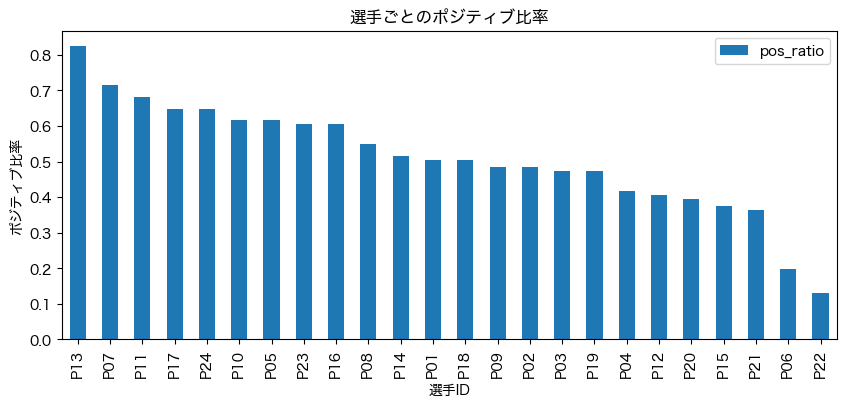

In [169]:
import matplotlib.pyplot as plt

# フォント設定（Mac）
plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['axes.unicode_minus'] = False

# グラフ表示
ax = feat_player.sort_values('pos_ratio', ascending=False).plot(
    x='player_id', y='pos_ratio', kind='bar', figsize=(10,4)
)
ax.set_ylabel('ポジティブ比率')
ax.set_xlabel('選手ID')
ax.set_title('選手ごとのポジティブ比率')

# 結果を保存
plt.savefig('positive_ratio_bar.png', bbox_inches='tight', dpi=300)

# 表示
plt.show()

## 追加の特徴量の作成

In [172]:
# neg_ratio：ポジティブに対するネガティブの比率
feat_player['neg_pos_ratio'] = feat_player['neg_ratio'] / (feat_player['pos_ratio'] + 1e-5)

# sent_mean + sent_std：感情の変動範囲の上限の目安
feat_player['sent_range'] = feat_player['sent_mean'] + feat_player['sent_std']

# stability：感情の安定性を示す指標。平均に対して標準偏差が小さいほど安定していると評価。
feat_player['stability'] = 1 - (feat_player['sent_std'] / (abs(feat_player['sent_mean']) + 1e-5))

# 作成した特徴量の先頭10行を表示して確認
feat_player.head(10)

,player_id,sent_mean,sent_std,pos_ratio,neg_ratio,len_mean,roll7_last,neg_pos_ratio,sent_range,stability
0,P01,0.615385,1.306133,0.505495,0.153846,46.186813,1.285714,0.304342,1.921517,-1.122431
1,P02,0.681319,1.094218,0.483516,0.065934,45.362637,1.571429,0.136361,1.775537,-0.606007
2,P03,0.681319,1.263849,0.472527,0.131868,43.483516,1.571429,0.279064,1.945167,-0.854977
3,P04,0.296703,0.888125,0.417582,0.142857,44.274725,0.285714,0.342097,1.184829,-1.993211
4,P05,0.758242,1.204996,0.615385,0.153846,40.956044,0.285714,0.249996,1.963237,-0.589176
5,P06,0.032967,0.836003,0.197802,0.164835,44.494505,0.285714,0.833291,0.868970,-24.351069
6,P07,1.142857,1.252299,0.714286,0.076923,38.593407,1.285714,0.107691,2.395157,-0.095752
7,P08,0.516484,1.369206,0.549451,0.186813,42.571429,0.142857,0.339994,1.885690,-1.650965
8,P09,0.285714,0.957841,0.483516,0.208791,43.340659,0.714286,0.431809,1.243556,-2.352328
9,P10,0.912088,1.347000,0.615385,0.186813,40.791209,0.857143,0.303566,2.259087,-0.476815


## STEP5 K-meansによる選手クラスタリング
#### 目的：作成した特徴量を用いて、選手を似た者同士のグループ（クラスタ）に分類する。

### 必要なライブラリをインポート

In [176]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

### クラスタリングの実行と可視化

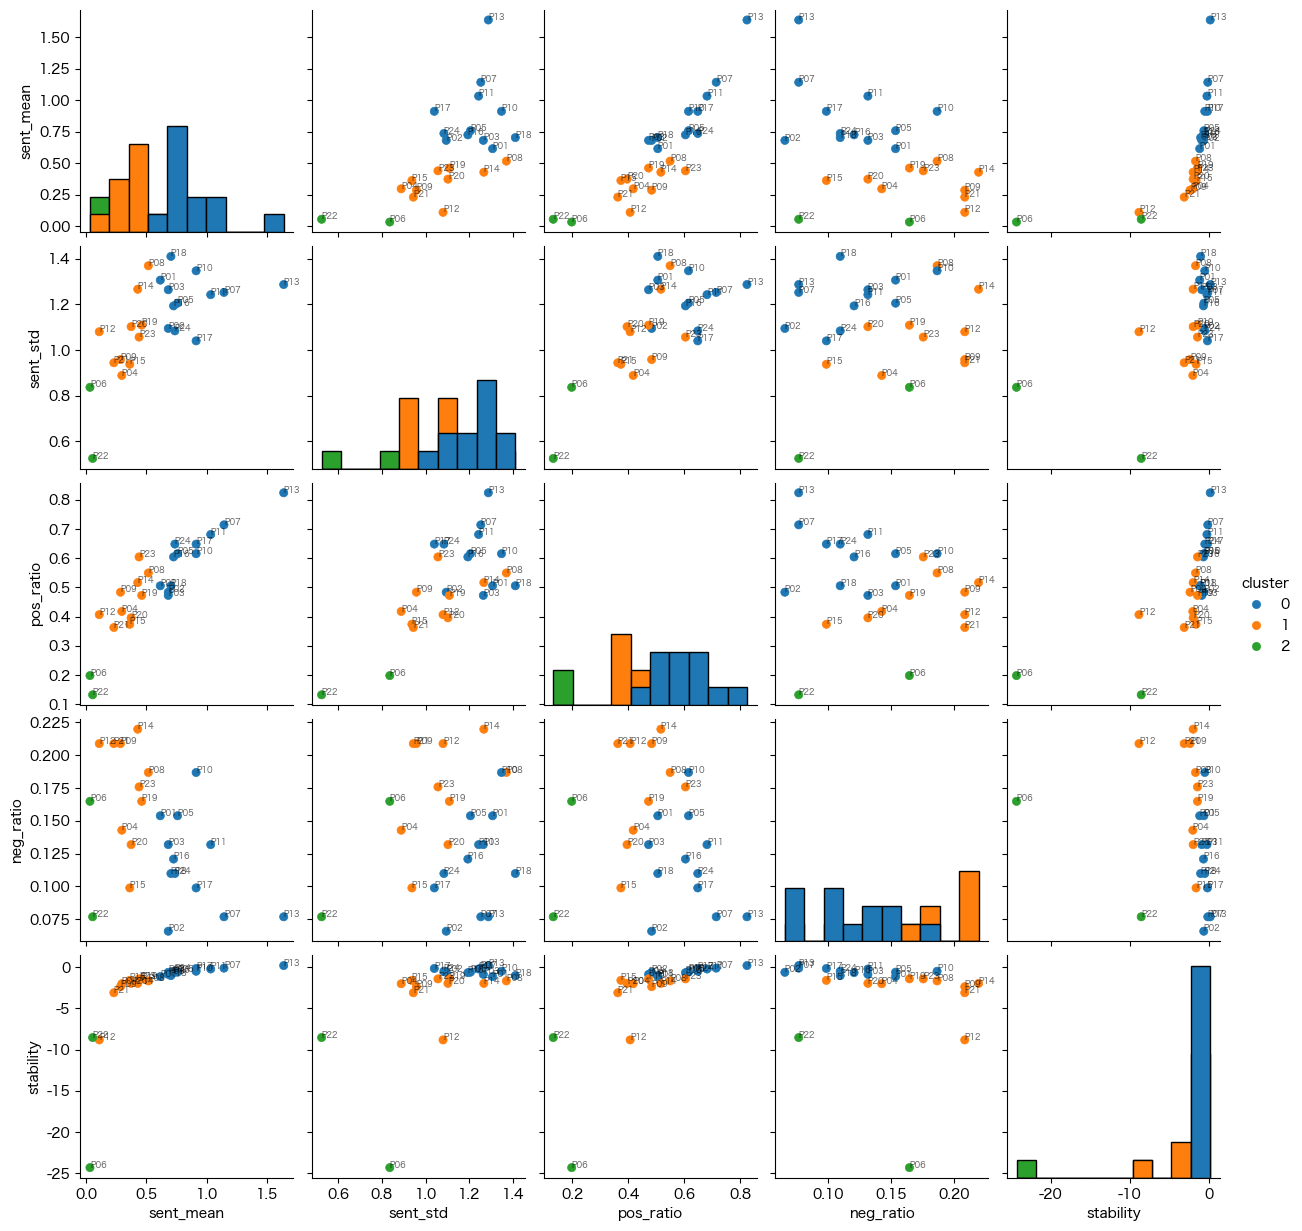

saved: player_clusters.png


In [179]:
# クラスタリングに使用する特徴量の列名を指定する。
cols = ['sent_mean', 'sent_std', 'pos_ratio', 'neg_ratio', 'stability']

# 'stability'の計算で生じた無限大（inf）などの異常値を中央値で補完する。
num = feat_player[cols].replace([np.inf, -np.inf], np.nan)
num = num.fillna(num.median())

# 'StandardScaler'を使って、各特徴量のスケール（単位や大きさ）を揃える。
# これにより、特定の特徴量だけがクラスタリングに強く影響するのを防ぐ。
X = StandardScaler().fit_transform(num)

# K-meansクラスタリングを実行する。
# 'n_clusters=3'：選手を3つのグループに分けることを指定する。
# 'random_state=0'：誰が実行しても同じ結果になるように乱数を固定。
# 'n_init=10'：計算の初期値を変えて10回実行し、最も良い結果を採用する。
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)

# 'fit_predict'でクラスタリングを実行し、各選手がどのクラスタに属するかを予測する。
feat_player['cluster'] = kmeans.fit_predict(X)

# 可視化のためのデータフレームの準備
df_plot = feat_player.copy()
df_plot[cols] = num.values

# クラスタごとの色を固定
cluster_palette = {0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c'} 

# `seaborn.pairplot`を使って、クラスタリングの結果を可視化する。
# 各特徴量の組み合わせの散布図と、各特徴量のヒストグラムをクラスタごとに色分けして表示する。
# これにより、各クラスタがどのような特徴を持つのかを視覚的に理解できる。
g = sns.pairplot(
    df_plot, vars=cols, hue="cluster",
    palette=cluster_palette,
    diag_kind="hist", corner=False,
    plot_kws=dict(alpha=1.0, s=35, edgecolor=None),  # ← alpha=1.0 で完全色
    diag_kws=dict(alpha=1.0, bins=10, edgecolor='black')  # ← ヒストも同じ
)

# 選手IDラベル
for i, yvar in enumerate(cols):          # 行（y軸）
    for j, xvar in enumerate(cols):      # 列（x軸）
        if i == j:
            continue  # 対角(ヒスト)はスキップ
        ax = g.axes[i, j]
        # 各点にIDを描く
        for _, row in df_plot.iterrows():
            x = row[xvar]   # ← 列名で取得（数値）
            y = row[yvar]   # ← 列名で取得（数値）
            if np.isfinite(x) and np.isfinite(y):
                ax.text(x, y, str(row['player_id']),
                        fontsize=6, alpha=0.6, color='black')

g.savefig('player_clusters.png', dpi=300, bbox_inches='tight') # グラフを画像として保存
plt.show()
print('saved: player_clusters.png')

## クラスタリング結果と日次データを結合

In [181]:
# 'df_split'を元に、7日間移動平均の列を持つ'df_daily'を作成する。
df_daily = df_split.copy()
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily = df_daily.sort_values(['player_id', 'date'])

# 7日ローリング（最低3点で計算）
df_daily['sent_roll7'] = (
    df_daily.groupby('player_id')['sent_score']
            .transform(lambda s: s.rolling(window=7, min_periods=3).mean())
)

# 日々のデータ（df_daily）と、選手ごとのクラスタ情報（feat_player）を結合する。
# これにより、各ノートがどのクラスタの選手によって書かれたかが分かるようになる。
df_merged = df_daily.merge(
    feat_player[['player_id', 'cluster']],
    on='player_id', how='left'
)

## クラスタごとの感情スコアの時系列変化を可視化

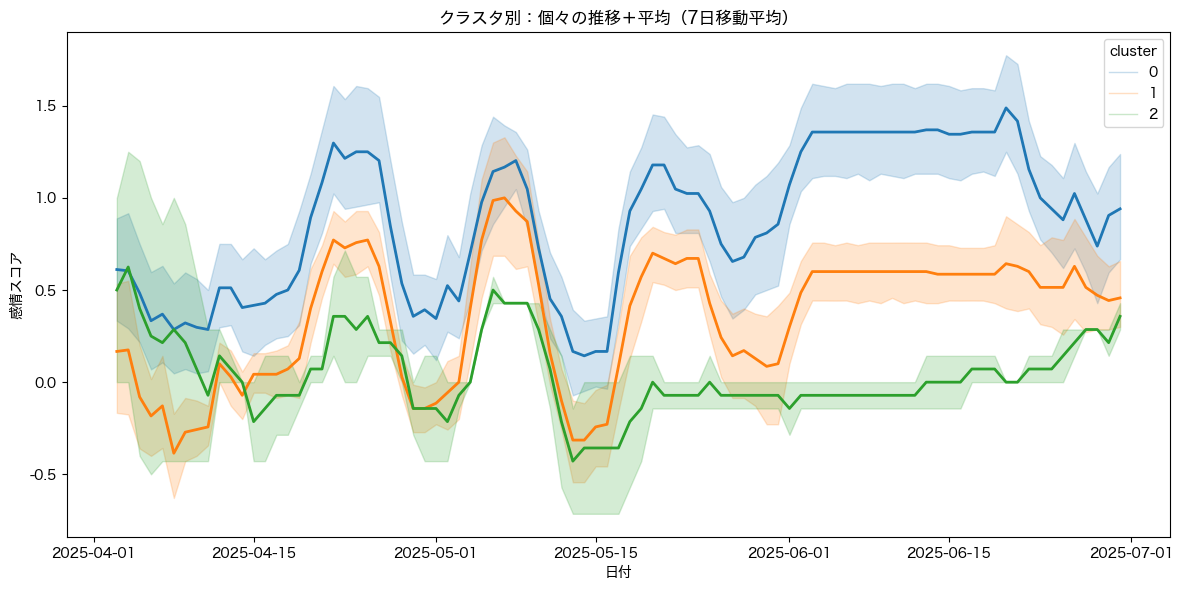

saved: cluster_sentiment_trend.png


In [183]:
# グラフの書式設定
plt.rcParams['font.family'] = 'Hiragino Sans' # Mac用の日本語フォント
plt.rcParams['axes.unicode_minus'] = False

# クラスタごとの固定カラー（例：クラスタ0〜2）
cluster_colors = {0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c'}

# グラフのサイズを設定
plt.figure(figsize=(12,6))

# `seaborn.lineplot`で、感情スコアの7日間移動平均の推移をクラスタごとに描画する。
# `lw=1, alpha=0.25`: まずは個々の選手の推移を薄い線で描画する。
sns.lineplot(
    data=df_merged, x='date', y='sent_roll7',
    hue='cluster', lw=1, alpha=0.25, legend=True, palette=cluster_colors
)

# `estimator="mean", lw=2`: 次に、各クラスタの平均値を太線で重ねて描画する。
# これにより、全体的な傾向と個々のばらつきを同時に確認できる。
sns.lineplot(
    data=df_merged, x='date', y='sent_roll7',
    hue='cluster', estimator='mean', errorbar=None, lw=2, palette=cluster_colors, legend=False
)
plt.title('クラスタ別：個々の推移＋平均（7日移動平均）')
plt.xlabel('日付')
plt.ylabel('感情スコア')
plt.tight_layout()

# 保存を追加（表示より前）
plt.savefig('cluster_sentiment_trend.png', bbox_inches='tight', dpi=300)

# 表示
plt.show()
print("saved: cluster_sentiment_trend.png")

## クラスタの解釈

In [185]:
# 各クラスタの平均値を計算
# 各クラスタがどのような特徴を持つか、平均値を計算して確認する。
# この結果から、各クラスタの選手像を定義する。
# 例：
# ・cluster 0：ネガティブな日が多く、感情の波も大きい「悩みがちタイプ」
# ・cluster 1：全体的にポジティブで、安定している「優等生タイプ」
# ・cluster 2：ポジティブな日が多いが、感情の波もややある「ムラがある天才肌タイプ」
cluster_summary = feat_player.groupby('cluster')[cols].mean()
print(cluster_summary)

         sent_mean  sent_std  pos_ratio  neg_ratio  stability
cluster                                                      
0         0.878205  1.227031   0.609890   0.118132  -0.499636
1         0.350549  1.070868   0.458242   0.174725  -2.620209
2         0.043956  0.680073   0.164835   0.120879 -16.444363


## 指導方針の提案ロジックの実装

In [187]:
# クラスタの解釈に基づいて、コーチングの方針を提案する関数を定義する。
# この部分が、このAIの最終的なアウトプットになる。
def get_coaching_advice(cluster_id):
    # 例として、前のセルの分析結果に基づいてアドバイスを定義する。
    # この内容の部分は分析者が自由に定義・改善できる。
    if cluster_id == 0:
        advice = '【悩みがちタイプ】感情の波が大きく、精神的な浮き沈みがプレーに影響しやすいようです。まずは大輔コーチによるメンタルケアや、ポジティブな声かけで自信を持たせることが重要です。結果を急かさず、寄り添う姿勢が効果的です。'
    elif cluster_id == 1:
        advice = '【優等生タイプ】精神的に安定し、高いパフォーマンスを継続できる選手です。塚本コーチによる高度な技術指導や、藤井監督による更なる高い目標設定で、さらなる成長が期待できます。'
    elif cluster_id == 2:
        advice = '【ムラがある天才肌タイプ】調が良い時は素晴らしいパフォーマンスを発揮しますが、精神的な浮き沈みも見られます。調子が良い時には塚本コーチと技術を突き詰め、不調な時には大輔コーチが精神的な支えとなるような、両コーチによる指導の使い分けが効果的です。'
    else:
        advice = '分析中です。'
    return advice

# 各選手にアドバイスを付与し、結果を確認する。
feat_player['advice'] = feat_player['cluster'].apply(get_coaching_advice)
print(feat_player[['player_id', 'cluster', 'advice']].head())

  player_id  cluster                                             advice
0       P01        0  【悩みがちタイプ】感情の波が大きく、精神的な浮き沈みがプレーに影響しやすいようです。まずは大...
1       P02        0  【悩みがちタイプ】感情の波が大きく、精神的な浮き沈みがプレーに影響しやすいようです。まずは大...
2       P03        0  【悩みがちタイプ】感情の波が大きく、精神的な浮き沈みがプレーに影響しやすいようです。まずは大...
3       P04        1  【優等生タイプ】精神的に安定し、高いパフォーマンスを継続できる選手です。塚本コーチによる高度...
4       P05        0  【悩みがちタイプ】感情の波が大きく、精神的な浮き沈みがプレーに影響しやすいようです。まずは大...
